In [1]:
import tarfile
import os

# Path to the tgz file
TGZ_PATH = "/kaggle/input/flower/102flowers.tgz"
EXTRACT_PATH = "/kaggle/working/flowers_jpg"

os.makedirs(EXTRACT_PATH, exist_ok=True)

# Extract tgz
with tarfile.open(TGZ_PATH, 'r:gz') as tar:
    tar.extractall(path=EXTRACT_PATH)

print("✅ Extraction complete. Images saved to:", EXTRACT_PATH)


✅ Extraction complete. Images saved to: /kaggle/working/flowers_jpg


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

INPUT_DIR = os.path.join(EXTRACT_PATH, "jpg")  
OUTPUT_DIR = "/kaggle/working/flowers_preprocessed"
os.makedirs(OUTPUT_DIR, exist_ok=True)

IMG_SIZE = 224   # standard size for CNNs

def preprocess_and_save(img_path, save_path, size=IMG_SIZE):
    img = cv2.imread(img_path)
    if img is None:
        return False
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Remove very small/invalid images
    if img.shape[0] < 50 or img.shape[1] < 50:
        return False
    
    img = cv2.resize(img, (size, size))
    img = img.astype(np.float32) / 255.0
    
    np.save(save_path, img)
    return True

valid, invalid = 0, 0
for fname in tqdm(os.listdir(INPUT_DIR)):
    in_path = os.path.join(INPUT_DIR, fname)
    out_path = os.path.join(OUTPUT_DIR, fname.split('.')[0])
    if preprocess_and_save(in_path, out_path):
        valid += 1
    else:
        invalid += 1

print(f"✅ Preprocessing finished. Valid: {valid}, Removed: {invalid}")


100%|██████████| 8189/8189 [00:27<00:00, 295.69it/s]

✅ Preprocessing finished. Valid: 8189, Removed: 0


In [3]:
import os


print("Files saved in:", OUTPUT_DIR)
print("Sample files:", os.listdir(OUTPUT_DIR)[:10])


first_file = os.path.join(OUTPUT_DIR, os.listdir(OUTPUT_DIR)[0])
print("First saved file path:", first_file)


Files saved in: /kaggle/working/flowers_preprocessed
Sample files: ['image_04805.npy', 'image_05152.npy', 'image_02256.npy', 'image_04703.npy', 'image_03116.npy', 'image_03887.npy', 'image_01971.npy', 'image_06644.npy', 'image_06687.npy', 'image_03659.npy']
First saved file path: /kaggle/working/flowers_preprocessed/image_04805.npy


# Exploring the dataset

✅ Total preprocessed images: 8189
Sample shape: (224, 224, 3)
Data type: float32
Pixel range: 0.0 to 1.0


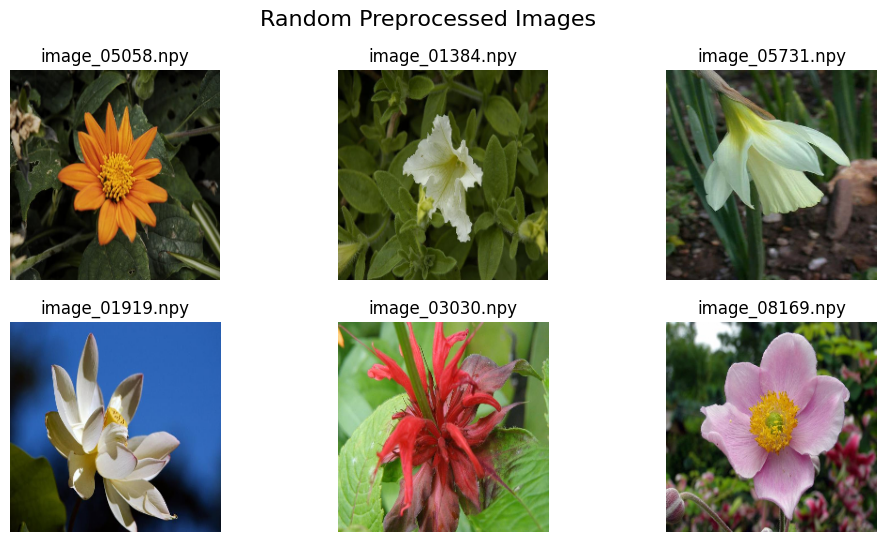

Dataset mean pixel value: 0.35768655
Dataset min pixel value: 0.0
Dataset max pixel value: 1.0


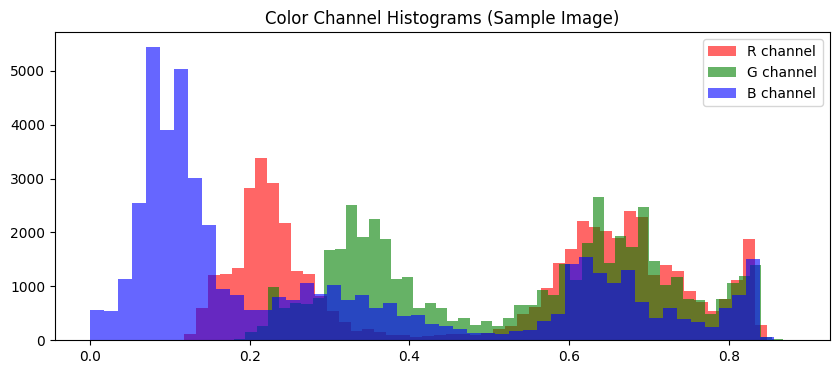

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random

# Path where npy files are saved
DATA_DIR = "/kaggle/working/flowers_preprocessed"

# 1. Count total images
files = [f for f in os.listdir(DATA_DIR) if f.endswith(".npy")]
print(f"✅ Total preprocessed images: {len(files)}")

# 2. Load one image to check shape & dtype
sample = np.load(os.path.join(DATA_DIR, files[0]))
print("Sample shape:", sample.shape)
print("Data type:", sample.dtype)
print("Pixel range:", sample.min(), "to", sample.max())

# 3. Visualize few random images
plt.figure(figsize=(12, 6))
for i in range(6):
    f = random.choice(files)
    img = np.load(os.path.join(DATA_DIR, f))
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title(f)
    plt.axis("off")
plt.suptitle("Random Preprocessed Images", fontsize=16)
plt.show()

# 4. Compute dataset-wide statistics
means, mins, maxs = [], [], []
for f in random.sample(files, min(200, len(files))):  # sample for speed
    img = np.load(os.path.join(DATA_DIR, f))
    means.append(img.mean())
    mins.append(img.min())
    maxs.append(img.max())

print("Dataset mean pixel value:", np.mean(means))
print("Dataset min pixel value:", np.min(mins))
print("Dataset max pixel value:", np.max(maxs))

# 5. Plot histograms for one random image (R, G, B channels)
img = np.load(os.path.join(DATA_DIR, random.choice(files)))
colors = ("r", "g", "b")
plt.figure(figsize=(10, 4))
for i, col in enumerate(colors):
    plt.hist(img[:, :, i].ravel(), bins=50, color=col, alpha=0.6, label=f"{col.upper()} channel")
plt.legend()
plt.title("Color Channel Histograms (Sample Image)")
plt.show()


# Color Feature Extraction

In [5]:
def extract_histogram(img, color_space='RGB', bins=(8, 8, 8)):
    """
    Extract histogram in RGB, HSV, or Lab color space.
    """
    if color_space == 'HSV':
        img = cv2.cvtColor((img*255).astype(np.uint8), cv2.COLOR_RGB2HSV)
    elif color_space == 'Lab':
        img = cv2.cvtColor((img*255).astype(np.uint8), cv2.COLOR_RGB2Lab)

    hist = cv2.calcHist([img], [0,1,2], None, bins, [0,256,0,256,0,256])
    cv2.normalize(hist, hist)
    return hist.flatten()

In [6]:
from scipy.stats import skew

def extract_color_moments(img):
    """
    Compute mean, std, skewness for each channel.
    Works for any 3-channel color space.
    """
    features = []
    for i in range(3):
        channel = img[:,:,i].ravel()
        features.append(np.mean(channel))
        features.append(np.std(channel))
        features.append(skew(channel))
    return np.array(features)


In [7]:
DATA_DIR = "/kaggle/working/flowers_preprocessed"
files = [f for f in os.listdir(DATA_DIR) if f.endswith(".npy")]

all_features = []

for f in files:
    img = np.load(os.path.join(DATA_DIR, f))  # already normalized
    
    # RGB Histogram + Moments
    rgb_hist = extract_histogram(img, "RGB")
    rgb_moments = extract_color_moments((img*255).astype(np.uint8))

    # HSV Histogram + Moments
    hsv_hist = extract_histogram(img, "HSV")
    hsv_img = cv2.cvtColor((img*255).astype(np.uint8), cv2.COLOR_RGB2HSV)
    hsv_moments = extract_color_moments(hsv_img)

    # Lab Histogram + Moments
    lab_hist = extract_histogram(img, "Lab")
    lab_img = cv2.cvtColor((img*255).astype(np.uint8), cv2.COLOR_RGB2Lab)
    lab_moments = extract_color_moments(lab_img)

    # Combine everything → Hybrid Color Feature Vector
    feature_vector = np.concatenate([
        rgb_hist, rgb_moments,
        hsv_hist, hsv_moments,
        lab_hist, lab_moments
    ])
    
    all_features.append(feature_vector)

all_features = np.array(all_features)
print("✅ Color feature extraction done.")
print("Hybrid feature shape:", all_features.shape)

# Save
np.save("/kaggle/working/color_hybrid_features.npy", all_features)
print("Saved at /kaggle/working/color_hybrid_features.npy")


✅ Color feature extraction done.
Hybrid feature shape: (8189, 1563)
Saved at /kaggle/working/color_hybrid_features.npy


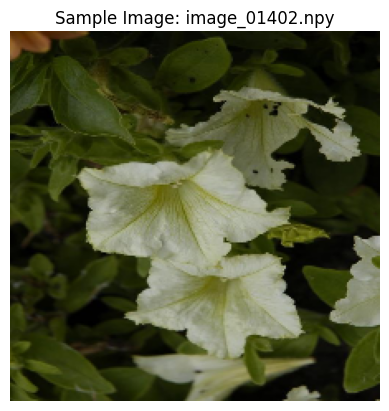

In [8]:
import random

# Load one random image
sample_file = random.choice(files)
sample_img = np.load(os.path.join(DATA_DIR, sample_file))

plt.imshow(sample_img)
plt.title(f"Sample Image: {sample_file}")
plt.axis("off")
plt.show()

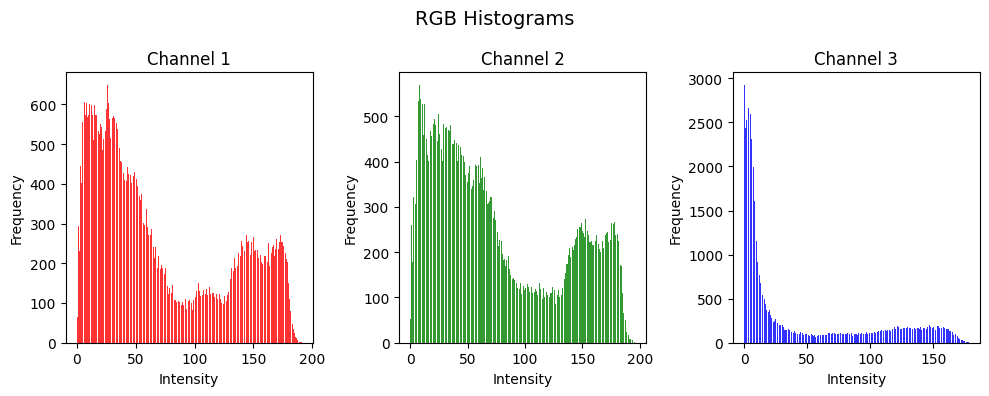

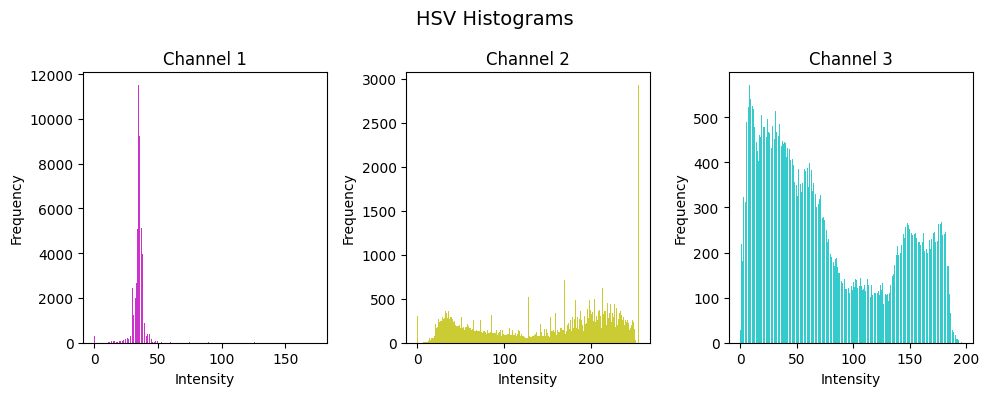

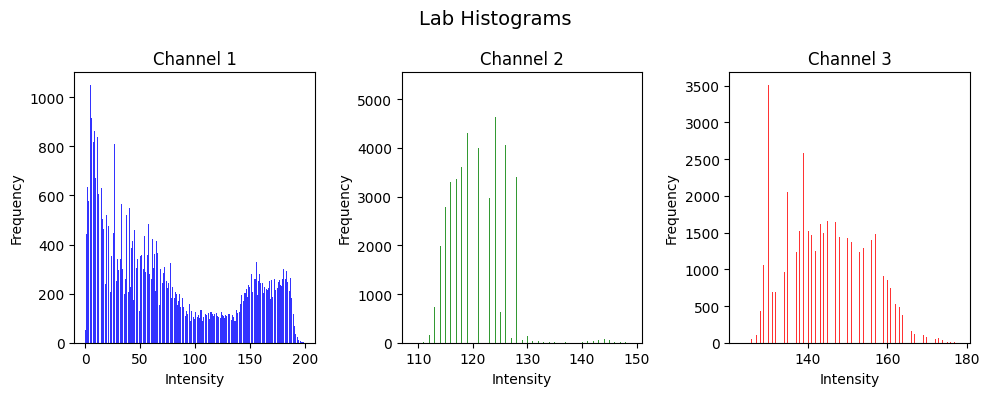

In [9]:
def plot_color_histograms(img):
    img_uint8 = (img*255).astype(np.uint8)

    # Convert
    hsv = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2HSV)
    lab = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2Lab)

    color_spaces = {
        "RGB": img_uint8,
        "HSV": hsv,
        "Lab": lab
    }
    colors = {
        "RGB": ["r", "g", "b"],
        "HSV": ["m", "y", "c"],
        "Lab": ["b", "g", "r"]
    }

    for space, image in color_spaces.items():
        plt.figure(figsize=(10,4))
        plt.suptitle(f"{space} Histograms", fontsize=14)

        for i, col in enumerate(colors[space]):
            plt.subplot(1,3,i+1)
            plt.hist(image[:,:,i].ravel(), bins=256, color=col, alpha=0.8)
            plt.title(f"Channel {i+1}")
            plt.xlabel("Intensity")
            plt.ylabel("Frequency")
        
        plt.tight_layout()
        plt.show()

# Run visualization
plot_color_histograms(sample_img)

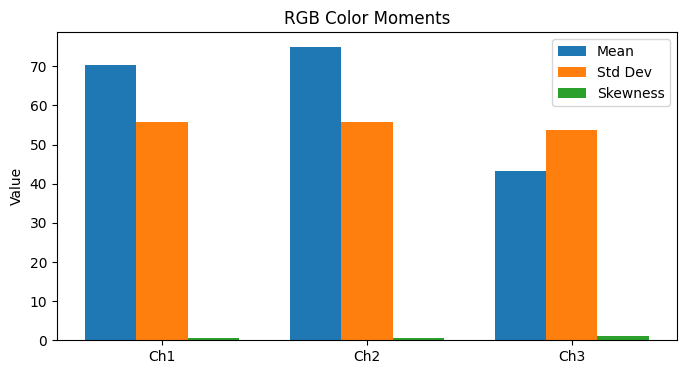

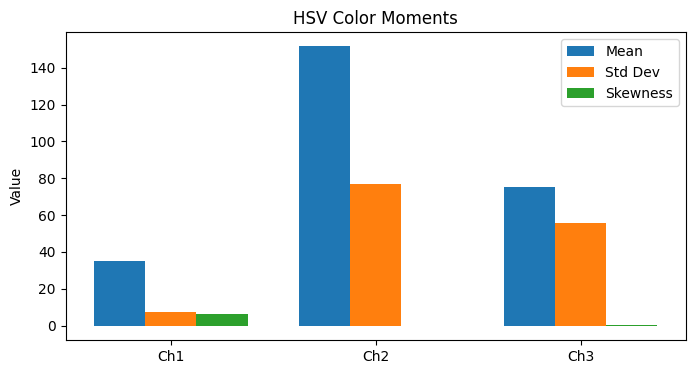

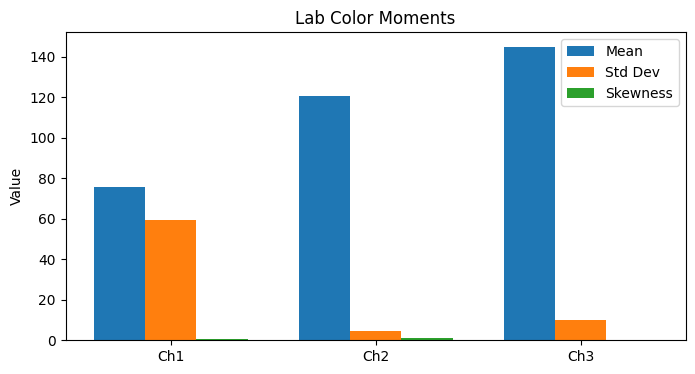

In [10]:
from scipy.stats import skew

def plot_color_moments(img):
    img_uint8 = (img*255).astype(np.uint8)

    # Convert to color spaces
    hsv = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2HSV)
    lab = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2Lab)

    color_spaces = {
        "RGB": img_uint8,
        "HSV": hsv,
        "Lab": lab
    }

    for space, image in color_spaces.items():
        means, stds, skews = [], [], []

        for i in range(3):  # 3 channels
            channel = image[:,:,i].ravel()
            means.append(np.mean(channel))
            stds.append(np.std(channel))
            skews.append(skew(channel))

        # Plot moments
        x = np.arange(3)
        width = 0.25

        plt.figure(figsize=(8,4))
        plt.bar(x - width, means, width, label="Mean")
        plt.bar(x, stds, width, label="Std Dev")
        plt.bar(x + width, skews, width, label="Skewness")

        plt.xticks(x, [f"Ch{i+1}" for i in range(3)])
        plt.ylabel("Value")
        plt.title(f"{space} Color Moments")
        plt.legend()
        plt.show()

# Run on sample image
plot_color_moments(sample_img)


# Text Feature Extraction

In [11]:
import numpy as np
import cv2
from skimage.feature import graycomatrix, graycoprops


def extract_glcm_features(img, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4]):
    """
    Extract GLCM features: contrast, correlation, energy, homogeneity.
    img: grayscale image
    """
    # Convert to grayscale
    gray = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    
    # Compute GLCM
    glcm = graycomatrix(gray, 
                        distances=distances, 
                        angles=angles, 
                        symmetric=True, 
                        normed=True)
    
    # Extract texture features
    contrast = graycoprops(glcm, 'contrast').mean()
    correlation = graycoprops(glcm, 'correlation').mean()
    energy = graycoprops(glcm, 'energy').mean()
    homogeneity = graycoprops(glcm, 'homogeneity').mean()
    
    return np.array([contrast, correlation, energy, homogeneity])


In [12]:
# Load one sample image
sample_path = "/kaggle/working/flowers_preprocessed/image_00547.npy"
img = np.load(sample_path)

# Extract GLCM features
glcm_features = extract_glcm_features(img)
print("GLCM Features:", glcm_features)

GLCM Features: [2.42723328e+02 9.81968241e-01 3.03932942e-02 2.57380301e-01]


In [13]:
from skimage.feature import local_binary_pattern

def extract_lbp_features(img, P=8, R=1):
    """
    Extract Local Binary Pattern (LBP) histogram features.
    P = number of circular neighbors
    R = radius of circle
    """
    gray = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

    # Compute LBP
    lbp = local_binary_pattern(gray, P, R, method="uniform")

    # Histogram of LBP values
    (hist, _) = np.histogram(lbp.ravel(),
                             bins=np.arange(0, P + 3),
                             range=(0, P + 2))

    # Normalize histogram
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)

    return hist


In [14]:
import matplotlib.pyplot as plt

def show_lbp_visualization(img, P=8, R=1):
    gray = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    lbp = local_binary_pattern(gray, P, R, method="uniform")

    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.imshow(gray, cmap="gray")
    plt.title("Original Grayscale")
    plt.axis("off")
    
    plt.subplot(1,2,2)
    plt.imshow(lbp, cmap="gray")
    plt.title("LBP Image")
    plt.axis("off")
    
    plt.show()


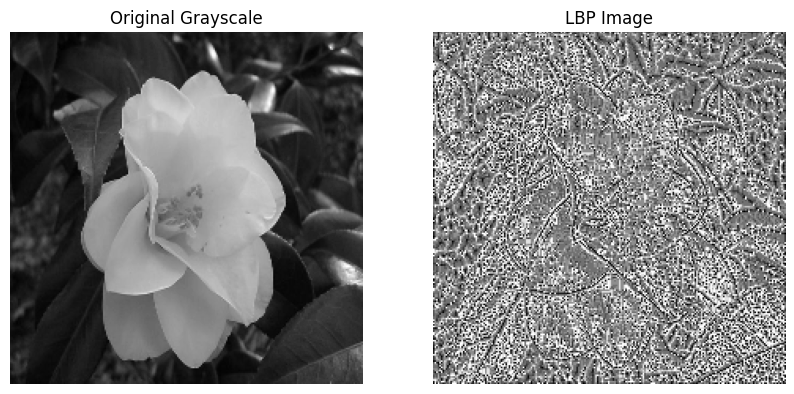

In [15]:
img = np.load("/kaggle/working/flowers_preprocessed/image_07614.npy")
show_lbp_visualization(img)


In [16]:
import pywt

def extract_wavelet_features(img, wavelet="db1", level=2):
    """
    Extract wavelet texture features from an image.
    - Uses Discrete Wavelet Transform (DWT).
    - Collects mean and std of coefficients from each channel.
    """
    features = []

    gray = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

    # Perform DWT
    coeffs = pywt.wavedec2(gray, wavelet=wavelet, level=level)

    for coeff in coeffs:
        if isinstance(coeff, tuple):  # detail coefficients (LH, HL, HH)
            for c in coeff:
                features.append(np.mean(c))
                features.append(np.std(c))
        else:  # approximation coefficients
            features.append(np.mean(coeff))
            features.append(np.std(coeff))

    return np.array(features)


In [17]:
img = np.load("/kaggle/working/flowers_preprocessed/image_07614.npy")
wavelet_feats = extract_wavelet_features(img)
print("Wavelet feature vector length:", len(wavelet_feats))

Wavelet feature vector length: 14


In [18]:
def extract_gabor_features(img, ksize=31, sigma=4.0, lambd=10.0, gamma=0.5, num_orientations=8):
    """
    Extract Gabor texture features from an image.
    - Applies Gabor filters at multiple orientations.
    - Returns mean & std of filtered responses.
    """
    gray = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    features = []

    for theta in np.linspace(0, np.pi, num_orientations, endpoint=False):
        # Create Gabor kernel
        kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, 0, ktype=cv2.CV_32F)

        # Filter the image
        fimg = cv2.filter2D(gray, cv2.CV_8UC3, kernel)

        # Collect statistical features
        features.append(np.mean(fimg))
        features.append(np.std(fimg))

    return np.array(features)


In [19]:
img = np.load("/kaggle/working/flowers_preprocessed/image_07614.npy")
gabor_feats = extract_gabor_features(img)
print("Gabor feature vector length:", len(gabor_feats))


Gabor feature vector length: 16


# Shape Feature Extraction

In [20]:
def extract_edges(img):
    """
    Extract edges using Canny and Sobel operators.
    Returns edge histograms as features.
    """
    gray = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

    # Canny edges
    canny_edges = cv2.Canny(gray, 100, 200)

    # Sobel edges (x and y)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    sobel_edges = cv2.magnitude(sobelx, sobely)

    # Histograms as features
    canny_hist = np.histogram(canny_edges.ravel(), bins=16, range=(0, 256))[0]
    sobel_hist = np.histogram(sobel_edges.ravel(), bins=16, range=(0, 256))[0]

    return np.concatenate([canny_hist, sobel_hist])


In [21]:
edge_feats = extract_edges(img)
print("Edge Features:", edge_feats.shape)


Edge Features: (32,)


In [22]:
def extract_contours(img):
    """
    Extract contour-based features: number of contours,
    average area, and average perimeter.
    """
    gray = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Binary mask for contours
    _, thresh = cv2.threshold(blurred, 127, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        return np.array([0, 0, 0])  # No contours found

    areas = [cv2.contourArea(c) for c in contours]
    perimeters = [cv2.arcLength(c, True) for c in contours]

    num_contours = len(contours)
    avg_area = np.mean(areas)
    avg_perimeter = np.mean(perimeters)

    return np.array([num_contours, avg_area, avg_perimeter])


In [23]:
contour_feats = extract_contours(img)
print("Contour Features:", contour_feats)


Contour Features: [ 20.         888.375       58.52655426]


In [24]:
from skimage.feature import hog

def extract_hog(img, pixels_per_cell=(8, 8), cells_per_block=(2, 2), orientations=9):
    """
    Extract HOG (Histogram of Oriented Gradients) features.
    """
    gray = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

    hog_features, hog_image = hog(
        gray,
        orientations=orientations,
        pixels_per_cell=pixels_per_cell,
        cells_per_block=cells_per_block,
        block_norm='L2-Hys',
        visualize=True
    )
    
    return hog_features, hog_image


HOG feature vector length: 26244


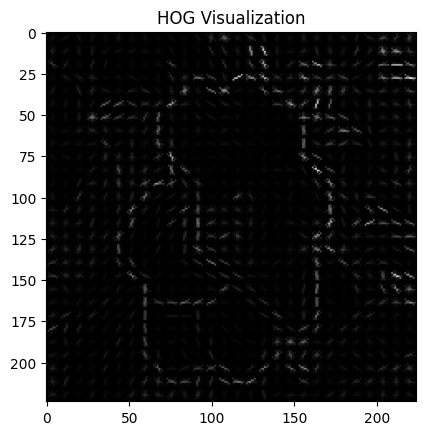

In [25]:
hog_features, hog_vis = extract_hog(img)
print("HOG feature vector length:", len(hog_features))

# Show visualization
plt.imshow(hog_vis, cmap="gray")
plt.title("HOG Visualization")
plt.show()


# Hybrid feature vector fusion 

In [26]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern, hog

# ---------- Feature Extractors ----------

def extract_color_histogram(img, bins=(8, 8, 8)):
    hist = cv2.calcHist([img], [0, 1, 2], None, bins, [0,256, 0,256, 0,256])
    cv2.normalize(hist, hist)
    return hist.flatten()

def extract_color_moments(img):
    moments = []
    for i in range(3):  # channels
        channel = img[:, :, i]
        mean = np.mean(channel)
        std = np.std(channel)
        skew = np.mean((channel - mean) ** 3)
        moments.extend([mean, std, skew])
    return np.array(moments)

def extract_glcm_features(img):
    gray = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    glcm = graycomatrix(gray, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                        symmetric=True, normed=True)
    feats = []
    for prop in ('contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM'):
        feats.append(graycoprops(glcm, prop).flatten())
    return np.hstack(feats)

def extract_lbp(img, P=8, R=1):
    gray = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    lbp = local_binary_pattern(gray, P, R, method="uniform")
    hist, _ = np.histogram(lbp.ravel(),
                           bins=np.arange(0, P + 3),
                           range=(0, P + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)
    return hist

def extract_hog(img):
    gray = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    features, _ = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2), block_norm='L2-Hys',
                      visualize=True, feature_vector=True)
    return features

# ---------- Hybrid Extractor ----------
def extract_hybrid_features(img):
    f1 = extract_color_histogram((img*255).astype(np.uint8))
    f2 = extract_color_moments((img*255).astype(np.uint8))
    f3 = extract_glcm_features(img)
    f4 = extract_lbp(img)
    f5 = extract_hog(img)
    return np.hstack([f1, f2, f3, f4, f5])

# ---------- Dataset Builder ----------
def build_feature_dataset(preprocessed_dir):
    features = []
    ids = []
    for fname in os.listdir(preprocessed_dir):
        if fname.endswith(".npy"):
            img = np.load(os.path.join(preprocessed_dir, fname))
            feats = extract_hybrid_features(img)
            features.append(feats)
            ids.append(fname)
    return pd.DataFrame(features, index=ids)

# ---------- Run ----------
df = build_feature_dataset("/kaggle/working/flowers_preprocessed/")
print("✅ Hybrid feature dataset shape:", df.shape)


✅ Hybrid feature dataset shape: (8189, 26799)


In [27]:
import numpy as np

data = np.load("/kaggle/working/color_hybrid_features.npy", allow_pickle=True)
print(type(data))
print(data.shape)
print(data[:2])   # show first 2 rows


<class 'numpy.ndarray'>
(8189, 1563)
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.49513014e+02
   1.85240905e+01 -3.03649579e-01]
 [ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.70484694e+02
   2.63408021e+01 -9.94422676e-02]]


In [28]:
import numpy as np
import pandas as pd

# Load hybrid features
data = np.load("/kaggle/working/color_hybrid_features.npy", allow_pickle=True)

# Split features and labels
features = data[:, :-1]   # all columns except last
labels = data[:, -1]      # last column is label

# Convert to DataFrame
features_df = pd.DataFrame(features)
features_df["label"] = labels

# Save to CSV
features_df.to_csv("/kaggle/working/hybrid_features.csv", index=False)

print("✅ Hybrid features with labels saved to /kaggle/working/hybrid_features.csv")


✅ Hybrid features with labels saved to /kaggle/working/hybrid_features.csv


# Genetic Algorithm

In [29]:
import pandas as pd
import numpy as np

CSV_PATH = "hybrid_features.csv"   # update if different
df = pd.read_csv(CSV_PATH)

has_labels = "label" in df.columns
if has_labels:
    y = df["label"].values
    X = df.drop(columns=["label"]).values
else:
    y = None
    X = df.values

n_samples, n_features = X.shape
print(f"X shape: {X.shape} | labels: {has_labels}")


X shape: (8189, 1562) | labels: True


In [30]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [31]:
# GA hyperparameters (tune as needed)
POP_SIZE     = 30
N_GENERATIONS= 20
TOURN_SIZE   = 3
PX           = 0.9   # crossover prob
PM           = 0.02  # mutation prob (per bit)
ALPHA        = 0.002 # penalty for fraction of selected features

# Safety: to avoid empty selections
MIN_FEATS = 5


In [32]:
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.cluster import KMeans

def _ensure_minimum(mask):
    """Guarantee at least MIN_FEATS selected."""
    if mask.sum() < MIN_FEATS:
        on_idx = np.random.choice(np.where(mask==0)[0], size=MIN_FEATS-mask.sum(), replace=False)
        mask[on_idx] = 1
    return mask

def fitness(mask):
    # convert mask to boolean np array
    mask = np.asarray(mask, dtype=bool)
    if mask.sum() == 0:
        return -1e9  # avoid empty set

    Xsel = X_scaled[:, mask]
    penalty = ALPHA * (mask.sum() / len(mask))  # soft penalty for size

    if has_labels:
        # 3-fold stratified KNN accuracy
        skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        accs = []
        for tr, va in skf.split(Xsel, y):
            clf = KNeighborsClassifier(n_neighbors=5, weights="distance")
            clf.fit(Xsel[tr], y[tr])
            pred = clf.predict(Xsel[va])
            accs.append(accuracy_score(y[va], pred))
        score = np.mean(accs) - penalty
    else:
        # Unsupervised: silhouette score with k-means
        # Heuristic for clusters
        k = min(20, max(2, int(np.sqrt(n_samples/2))))
        km = KMeans(n_clusters=k, n_init=5, random_state=42)
        labels_km = km.fit_predict(Xsel)
        # silhouette requires at least 2 clusters and < n_samples clusters
        if len(np.unique(labels_km)) < 2 or len(np.unique(labels_km)) >= len(labels_km):
            return -1e9
        score = silhouette_score(Xsel, labels_km, metric="euclidean") - penalty

    return score


In [33]:
import numpy as np
import pandas as pd

# Load features
data = np.load("/kaggle/working/color_hybrid_features.npy", allow_pickle=True)

# Split features/labels
X = data[:, :-1]
y = data[:, -1]

# Convert labels to integers if they are floats
y = y.astype(int)

print("X shape:", X.shape)
print("y shape:", y.shape, "unique labels:", np.unique(y))


X shape: (8189, 1562)
y shape: (8189,) unique labels: [-3 -2 -1  0  1  2  3  4  5  6  7  8]


In [34]:
from collections import Counter

counts = Counter(y)
valid_classes = [cls for cls, c in counts.items() if c > 2]  # keep only classes with >2 samples
mask = np.isin(y, valid_classes)
X, y = X[mask], y[mask]

print("✅ Filtered data shape:", X.shape, "labels:", np.unique(y))


✅ Filtered data shape: (8184, 1562) labels: [-2 -1  0  1  2  3  4  5]


In [35]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
import numpy as np

# scale once globally
scaler = StandardScaler()
X = scaler.fit_transform(X)

def fitness(mask):
    selected = np.where(mask == 1)[0]
    if len(selected) == 0:
        return 0
    X_sel = X[:, selected]

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = []
    for train, test in skf.split(X_sel, y):
        clf = LogisticRegression(max_iter=2000, solver='lbfgs')
        clf.fit(X_sel[train], y[train])
        scores.append(clf.score(X_sel[test], y[test]))
    return np.mean(scores)


In [36]:
rng = np.random.default_rng(42)

def init_individual(p_select=0.02):
    """Sparse mask to start; ensures minimum features."""
    mask = (rng.random(n_features) < p_select).astype(np.uint8)
    return _ensure_minimum(mask)

def tournament_select(pop, k=TOURN_SIZE):
    # higher fitness is better
    cand_idx = rng.choice(len(pop), size=k, replace=False)
    best = max(cand_idx, key=lambda i: pop[i][1])
    return pop[best][0].copy()

def uniform_crossover(a, b, px=PX):
    if rng.random() > px:
        return a.copy(), b.copy()
    mask = rng.integers(0, 2, size=a.shape, dtype=np.uint8)
    c1 = (a & mask) | (b & (1 - mask))
    c2 = (b & mask) | (a & (1 - mask))
    return c1, c2

def mutate(ind, pm=PM):
    flip = rng.random(ind.shape[0]) < pm
    ind[flip] = 1 - ind[flip]
    _ensure_minimum(ind)
    return ind

def evaluate_population(pop_masks):
    return [(ind, fitness(ind)) for ind in pop_masks]

def evolve():
    # init population
    pop = [init_individual() for _ in range(POP_SIZE)]
    pop = evaluate_population(pop)

    best = max(pop, key=lambda x: x[1])
    history = [best[1]]

    for gen in range(N_GENERATIONS):
        new_pop = []

        # elitism: keep top-2
        elites = sorted(pop, key=lambda x: x[1], reverse=True)[:2]
        new_pop.extend([e[0].copy() for e in elites])

        # generate rest
        while len(new_pop) < POP_SIZE:
            p1 = tournament_select(pop)
            p2 = tournament_select(pop)
            c1, c2 = uniform_crossover(p1, p2)
            c1 = mutate(c1)
            c2 = mutate(c2)
            new_pop.extend([c1, c2])

        # trim if overshoot
        new_pop = new_pop[:POP_SIZE]

        # evaluate
        pop = evaluate_population(new_pop)

        # track best
        gen_best = max(pop, key=lambda x: x[1])
        if gen_best[1] > best[1]:
            best = (gen_best[0].copy(), gen_best[1])

        history.append(best[1])
        print(f"Gen {gen+1}/{N_GENERATIONS} | Best fitness: {best[1]:.5f} | Selected: {best[0].sum()}")

    return best, history

best_solution, history = evolve()
best_mask, best_score = best_solution
print("\n✅ GA finished")
print("Best fitness:", best_score)

print("Selected features:", int(best_mask.sum()))

Gen 1/20 | Best fitness: 0.75024 | Selected: 70
Gen 2/20 | Best fitness: 0.75024 | Selected: 70
Gen 3/20 | Best fitness: 0.75318 | Selected: 117
Gen 4/20 | Best fitness: 0.75745 | Selected: 120
Gen 5/20 | Best fitness: 0.76087 | Selected: 157
Gen 6/20 | Best fitness: 0.76307 | Selected: 193
Gen 7/20 | Best fitness: 0.76552 | Selected: 199
Gen 8/20 | Best fitness: 0.76723 | Selected: 215
Gen 9/20 | Best fitness: 0.76906 | Selected: 227
Gen 10/20 | Best fitness: 0.76979 | Selected: 239
Gen 11/20 | Best fitness: 0.76992 | Selected: 262
Gen 12/20 | Best fitness: 0.77419 | Selected: 301
Gen 13/20 | Best fitness: 0.77529 | Selected: 319
Gen 14/20 | Best fitness: 0.77529 | Selected: 319
Gen 15/20 | Best fitness: 0.77676 | Selected: 337
Gen 16/20 | Best fitness: 0.77933 | Selected: 351
Gen 17/20 | Best fitness: 0.77933 | Selected: 351
Gen 18/20 | Best fitness: 0.77933 | Selected: 351
Gen 19/20 | Best fitness: 0.78165 | Selected: 388
Gen 20/20 | Best fitness: 0.78165 | Selected: 388

✅ GA finis

In [37]:
import json

selected_idx = np.where(best_mask == 1)[0].tolist()

# save indices
with open("ga_selected_features.json", "w") as f:
    json.dump({"selected_indices": selected_idx, "score": float(best_score)}, f)

# save reduced feature matrix (and labels if present)
X_sel = X[:, selected_idx]  # use *unscaled* values for storage, scale later during modeling
np.save("X_selected.npy", X_sel)
if has_labels:
    np.save("y.npy", y)

print(f"Saved {len(selected_idx)} selected features to ga_selected_features.json")
print(f"Saved reduced matrix to X_selected.npy (shape {X_sel.shape})")
if has_labels:
    print("Saved labels to y.npy")


Saved 388 selected features to ga_selected_features.json
Saved reduced matrix to X_selected.npy (shape (8184, 388))
Saved labels to y.npy


In [38]:
if has_labels:
    from sklearn.model_selection import train_test_split
    from sklearn.pipeline import make_pipeline

    Xtr, Xte, ytr, yte = train_test_split(X_sel, y, test_size=0.2, random_state=42, stratify=y)

    pipe = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=5, weights="distance"))
    pipe.fit(Xtr, ytr)
    print("Held-out accuracy (KNN):", pipe.score(Xte, yte))


Held-out accuracy (KNN): 0.773365913255956
